# Import Packages

In [40]:
import os
import json
import csv
import cv2
import numpy as np
import re

# Load JSON File

In [41]:
with open('filtered-data.json') as f:
    json_data = json.load(f)

json_data

{'0': {'path': 'X5QyQarnTvptzmiCAQKRNBWZBCnrZEJ4RV4X4r2tdqCjOnvst5tHbVNWd35wGwHL',
  'type': 'estonia_none_idcard_design2',
  'angle': 0,
  'size': [1024, 661],
  'yolo_result': '25,1025,2,648',
  'ocr': {'EESTI': [{'y': 0.69742817, 'x': 0.6230469},
    {'y': 0.6944024, 'x': 0.6640625},
    {'y': 0.7170953, 'x': 0.66503906},
    {'y': 0.720121, 'x': 0.62402344}],
   'VABARIIK': [{'y': 0.054462936, 'x': 0.17089844},
    {'y': 0.057488654, 'x': 0.3125},
    {'y': 0.093797274, 'x': 0.3125},
    {'y': 0.090771556, 'x': 0.17089844}],
   'Republic': [{'y': 0.11043873, 'x': 0.08105469},
    {'y': 0.11043873, 'x': 0.1796875},
    {'y': 0.14220877, 'x': 0.1796875},
    {'y': 0.14220877, 'x': 0.08105469}],
   'of': [{'y': 0.11043873, 'x': 0.18457031},
    {'y': 0.11043873, 'x': 0.20898438},
    {'y': 0.14220877, 'x': 0.20898438},
    {'y': 0.14220877, 'x': 0.18457031}],
   'Estonia': [{'y': 0.11043873, 'x': 0.21289062},
    {'y': 0.11043873, 'x': 0.29785156},
    {'y': 0.14220877, 'x': 0.2978515

# Keywords for Categorization

In [42]:
personal_info_keywords = re.compile(r"(NAME|BIRTH|SEX|SEXO|M|F|GENDER|CITIZEN)", re.IGNORECASE)

# Features Extraction and Assign Category

In [43]:
def extract_features(json_data):
    features = []
    for key, value in json_data.items():
        if key != '0':  # Example to focus only on one key, adjust as needed
            continue
        path = value['path']
        type = value['type']
        angle = value['angle']
        size = value['size']
        yolo_result = value['yolo_result']
        ocr = value['ocr']
        
        for text, coordinates in ocr.items():
            x_coords = [coord['x'] for coord in coordinates]
            y_coords = [coord['y'] for coord in coordinates]
            
            category = "Unknown"
            if personal_info_keywords.search(text):
                category = "Personal Info"
                if text.upper() == "NAME" or text.upper() == "BIRTH":
                    category = "Personal Info"
            
            feature_vector = [
                path, 
                text, 
                x_coords,  # Original x coordinates
                y_coords,   # Original y coordinates
                category    # Category label
            ]
            features.append(feature_vector)
    
    return features

features = extract_features(json_data)


In [44]:
features

[['X5QyQarnTvptzmiCAQKRNBWZBCnrZEJ4RV4X4r2tdqCjOnvst5tHbVNWd35wGwHL',
  'EESTI',
  [0.6230469, 0.6640625, 0.66503906, 0.62402344],
  [0.69742817, 0.6944024, 0.7170953, 0.720121],
  'Unknown'],
 ['X5QyQarnTvptzmiCAQKRNBWZBCnrZEJ4RV4X4r2tdqCjOnvst5tHbVNWd35wGwHL',
  'VABARIIK',
  [0.17089844, 0.3125, 0.3125, 0.17089844],
  [0.054462936, 0.057488654, 0.093797274, 0.090771556],
  'Unknown'],
 ['X5QyQarnTvptzmiCAQKRNBWZBCnrZEJ4RV4X4r2tdqCjOnvst5tHbVNWd35wGwHL',
  'Republic',
  [0.08105469, 0.1796875, 0.1796875, 0.08105469],
  [0.11043873, 0.11043873, 0.14220877, 0.14220877],
  'Unknown'],
 ['X5QyQarnTvptzmiCAQKRNBWZBCnrZEJ4RV4X4r2tdqCjOnvst5tHbVNWd35wGwHL',
  'of',
  [0.18457031, 0.20898438, 0.20898438, 0.18457031],
  [0.11043873, 0.11043873, 0.14220877, 0.14220877],
  'Personal Info'],
 ['X5QyQarnTvptzmiCAQKRNBWZBCnrZEJ4RV4X4r2tdqCjOnvst5tHbVNWd35wGwHL',
  'Estonia',
  [0.21289062, 0.29785156, 0.29785156, 0.21289062],
  [0.11043873, 0.11043873, 0.14220877, 0.14220877],
  'Unknown'],
 ['X5Q

# Load Image

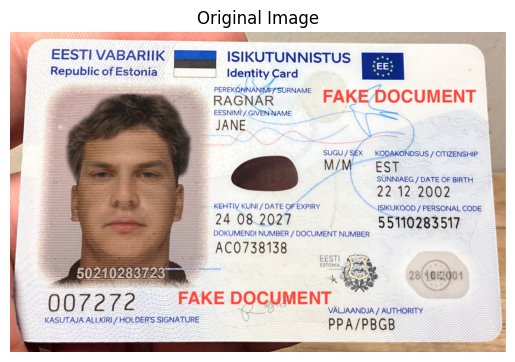

In [45]:
image_path = json_data['0']['path'] + ".jpeg"
image = cv2.imread(os.path.join('images', image_path))

from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.show()


# Cropping Image and Coordinates Recalculating and Adjustment

In [47]:
# Global variables for mouse cropping
start_x, start_y = 0, 0
end_x, end_y = 0, 0
cropping = False
cropped_image = None

def crop_image(event, x, y, flags, param):
    global start_x, start_y, end_x, end_y, cropping, cropped_image

    features = param['features']
    
    if event == cv2.EVENT_LBUTTONDOWN:
        start_x, start_y = x, y
        cropping = True

    elif event == cv2.EVENT_MOUSEMOVE:
        if cropping:
            end_x, end_y = x, y

            img_copy = image.copy()
            cv2.rectangle(img_copy, (start_x, start_y), (end_x, end_y), (0, 255, 0), 2)
            cv2.imshow('Original Image', img_copy)

    elif event == cv2.EVENT_LBUTTONUP:
        end_x, end_y = x, y
        cropping = False
        cropped_image = image[start_y:end_y, start_x:end_x]
        cv2.imshow('Cropped Image', cropped_image)
        
        recalculate_and_draw_coordinates(features, start_x, start_y, end_x - start_x, end_y - start_y, cropped_image)

def recalculate_and_draw_coordinates(features, crop_x, crop_y, crop_w, crop_h, cropped_image):
    for feature in features:
        x_coords = feature[2]
        y_coords = feature[3]
        
        # Normalizing coordinates to 0 - 1 range
        img_w, img_h = image.shape[1], image.shape[0]
        norm_x_coords = [x * img_w for x in x_coords]
        norm_y_coords = [y * img_h for y in y_coords]
        
        # Adjust coordinates based on the crop position
        re_x_coords = [(x - crop_x) / crop_w for x in norm_x_coords]
        re_y_coords = [(y - crop_y) / crop_h for y in norm_y_coords]
        
        re_x_coords = [min(max(0, x), 1) for x in re_x_coords]
        re_y_coords = [min(max(0, y), 1) for y in re_y_coords]
        
        # feature with recalculated coordinates
        feature[2] = re_x_coords
        feature[3] = re_y_coords

        draw_rectangles_on_cropped_image(cropped_image, re_x_coords, re_y_coords)

def draw_rectangles_on_cropped_image(cropped_image, x_coords, y_coords):
    num_coords = len(x_coords)
    for i in range(0, num_coords, 4):
        if i + 3 < num_coords:
            x1, y1 = int(x_coords[i] * cropped_image.shape[1]), int(y_coords[i] * cropped_image.shape[0])
            x2, y2 = int(x_coords[i+2] * cropped_image.shape[1]), int(y_coords[i+2] * cropped_image.shape[0])
            cv2.rectangle(cropped_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.imshow('Cropped Image with Rectangles', cropped_image)


# Set Up Mouse Callback and Start Cropping

In [48]:
cv2.imshow('Original Image', image)

cv2.setMouseCallback('Original Image', crop_image, {'features': features})

cv2.waitKey(0)
cv2.destroyAllWindows()


# Create CSV File

In [49]:
with open('features.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['path', 'word', 're_x_coords', 're_y_coords', 'category'])
    for feature in features:
        path = feature[0]
        word = feature[1]
        re_x_coords = feature[2]
        re_y_coords = feature[3]
        category = feature[4]
        writer.writerow([path, word, re_x_coords, re_y_coords, category])
